<a href="https://colab.research.google.com/github/valid999/Speech_Recognition/blob/main/Speech_Recognition_With_WAV2VEC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement with torchaudio
* torchaudio.piplines

### Steps
* Extract the acoustic features from audio waveforms
* Estimate the class of the acoustic features frame by frame
* Generate hypothesis from the sequence of the class probabilites


In [1]:
# Preparation
import torch
import  torchaudio


print(torch.__version__)
print(torchaudio.__version__)


torch.random.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2.0.1+cu118
2.0.2+cu118
cuda


In [2]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset


SPEECH_FILE = download_asset('tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav')

100%|██████████| 106k/106k [00:00<00:00, 79.7MB/s]


### First we will create the Wav2Vec2 model that performs the feature extraction  and the classification


In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate :" , bundle.sample_rate)
print('Labels :' , bundle.get_labels())

Sample Rate : 16000
Labels : ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


### Fetch the pretrained model

In [4]:
# Let's  fetch the pretrained model

model = bundle.get_model().to(device)
print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:05<00:00, 71.5MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


### Loading the data

In [5]:
IPython.display.Audio(SPEECH_FILE)

In [6]:
waveform , sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)


if sample_rate != bundle.sample_rate:
  waveform = torchaudio.functional.resample(waveform , sample_rate , bundle.sample_rate)

## Extracting acoustic features

In [7]:
with torch.inference_mode():
  features , _ = model.extract_features(waveform)

### The returned features is a list of tensor . Each tensor is the output of a transformer layer.


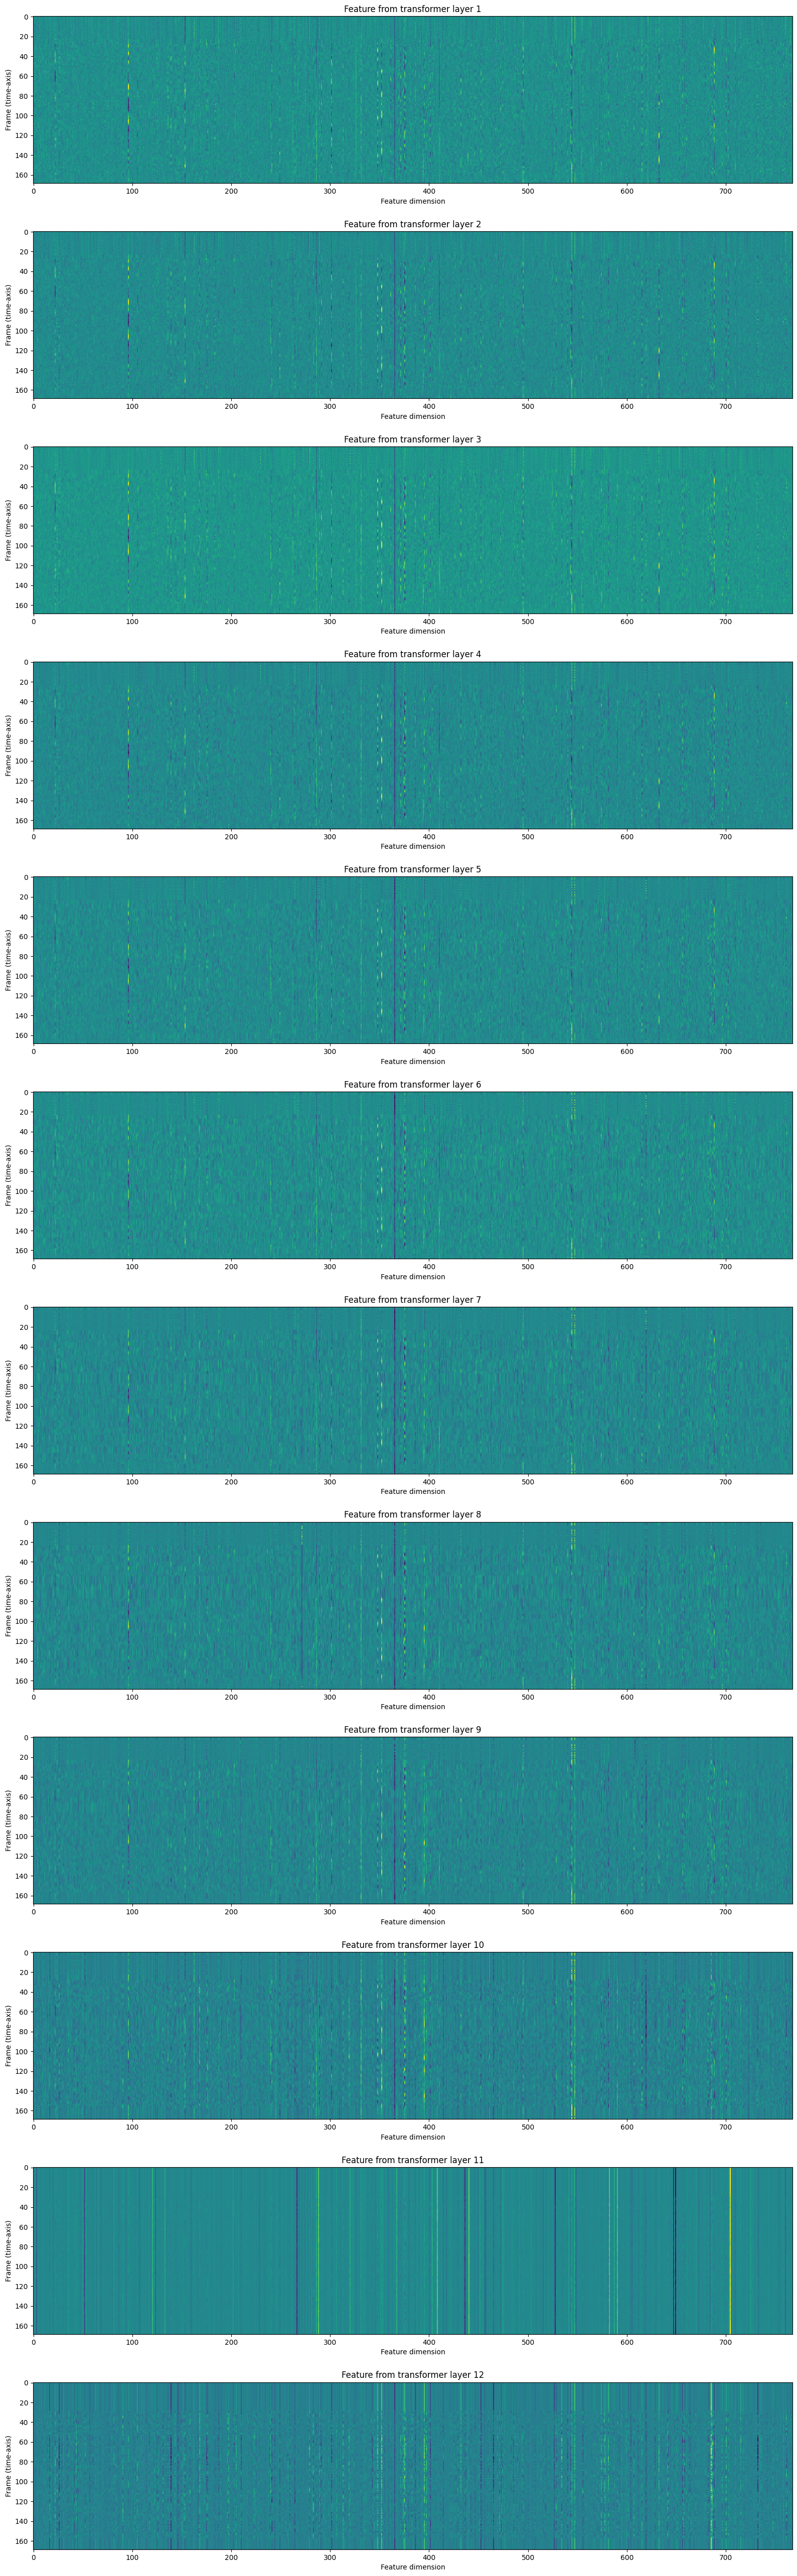

In [8]:
fig , ax = plt.subplots(len(features) , 1 , figsize = (16 , 4.3*len(features)))
for i , feats in enumerate(features):
  ax[i].imshow(feats[0].cpu() , interpolation = 'nearest')
  ax[i].set_title(f'Feature from transformer layer {i+1}')
  ax[i].set_xlabel("Feature dimension")
  ax[i].set_ylabel('Frame (time-axis)')
fig.tight_layout()

In [9]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


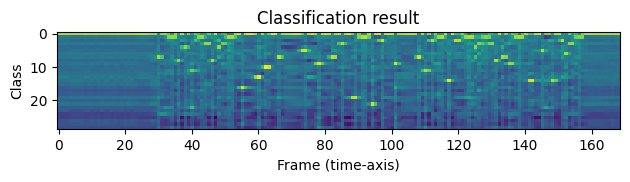

In [10]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [11]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [12]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [13]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [15]:
transcript

'I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|'

In [16]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|
